**Tutorial 1**

**Prerequisites: Julia Installation**

This tutorial uses **Julia programming language**. Before running any code, you need to install Julia:

1. **Download Julia**: Go to [https://julialang.org/downloads/](https://julialang.org/downloads/)
2. **Install**: Download the appropriate version for your operating system (Windows, macOS, or Linux)
3. **Verify**: Open Julia REPL (command line) and you should see the Julia prompt `julia>`

**Required Julia Packages**

**Before running this code:** make sure you have the required packages installed: `InteractiveIsing`, `Plots`, `GLMakie`, `FileIO`.

**Install via Julia's package manager**

```julia
using Pkg
Pkg.add(url="https://github.com/rug-minds/InteractiveIsing.jl")
Pkg.add("Plots")
Pkg.add("GLMakie")
Pkg.add("FileIO")
Pkg.add("CairoMakie")
```

**What this tutorial covers**

This tutorial demonstrates how to set up and run 3D Ising model simulations using the **InteractiveIsing.jl** package in Julia. You will learn to:
- Load packages and create 3D lattices
- Configure spin types and boundary conditions  
- Set up interactive visualization
- Run hysteresis loop simulations with external field pulses
- Analyze ferroelectric switching behavior

**Note**: All code in this tutorial is written in **Julia**. Make sure you're running it in a Julia environment (REPL, Jupyter notebook with Julia kernel, or VS Code with Julia extension).

In [ ]:
# Julia Code: Setup 3D Ising Model Simulation
# This code sets up a 3D Ising model simulation using the InteractiveIsing package in Julia.
# Make sure you're running this in a Julia environment.

# Load the necessary Julia packages and modules
using InteractiveIsing, Plots, GLMakie, FileIO
using InteractiveIsing.Processes
import InteractiveIsing as II

In [ ]:
# Initialize a 3D Ising graph with specified dimensions and periodic boundary conditions

xL = 100  # Length in the x-dimension
yL = 100  # Length in the y-dimension
zL = 10   # Length in the z-dimension

**Lattice Dimensions**
These three integers define the simulation lattice size:

| Variable | Meaning | Defined here | Notes |
|----------|---------|--------------|-------|
| `xL` | Number of sites along x | 100 | Often treat as width |
| `yL` | Number of sites along y | 100 | Often treat as height (in‑plane) |
| `zL` | Number of layers (thickness) | 10 | Keep smaller to reduce cost |

**Cost / Scaling**
- Spins N = xL * yL * zL = 100,000; one full sweep = N update attempts.
- Runtime ~ (#sweeps) * N * C_local; C_local grows mildly with neighbor range & Hamiltonian complexity.
- Spin storage (Float32 / Float64) ≈ 0.4 MB / 0.8 MB
- Adjacency (nearest-neighbor 3D) ≈ O(z * x * y * z_nn) entries; for 6 nn  ~12N nonzeros ⇒ ~10 MB (Float32 weights + Int32 indices) before overhead; larger NN expands roughly with (2rx+1)(2ry+1)(2rz+1).
- Extra: pulse trace arrays (length = lifetime / SpeedRate), Makie GPU buffers > spin array size.


**Spin Type and Boundary Conditions** 

Spin (dipole) value modes:
- Continuous(): soft/continuous spins (needed for self energy or multi‑level behavior).
- Discrete: binary ±1 (default meaning).
- Discrete with sets: custom finite levels (e.g. -1, -0.5, 0, 0.5, 1).

Boundary conditions:
- periodic = (:x,:y): periodic in-plane, open along z (film with two surfaces).
- periodic omitted (or explicit (:x,:y,:z)): fully periodic.
- periodic = false: all open boundaries.

Pick ONE graph object (assign to g) for later steps.

In [3]:
# === Choose spin representation and boundary conditions ===

# Option 1: Continuous spins, periodic in x,y only (recommended for thin film)
g_cont_xy = IsingGraph(xL, yL, zL, type = Continuous(), periodic = (:x,:y))

# Option 2: Continuous spins, fully periodic
g_cont_all = IsingGraph(xL, yL, zL, type = Continuous(), periodic = (:x,:y,:z))

# Option 3: Continuous spins, all open boundaries
g_cont_open = IsingGraph(xL, yL, zL, type = Continuous(), periodic = false)

# Option 4: Discrete binary spins (±1)
g_disc = IsingGraph(xL, yL, zL, type = Discrete, periodic = (:x,:y))

# Option 5: Discrete multi-level spins
g_disc_multi = IsingGraph(
    xL, yL, zL,
    type = Discrete,
    periodic = (:x,:y),
    sets = [(-1, -0.5, 0.0, 0.5, 1.0)]
)

# Select one for subsequent simulation:
g = g_cont_xy

Layers or WGs: (InteractiveIsing.LayerProperties((100, 100, 10), (stateset = nothing, stype = Continuous(), weights = nothing, periodic = (:x, :y))),)
layers_props = (InteractiveIsing.LayerProperties((100, 100, 10), (stateset = nothing, stype = Continuous(), weights = nothing, periodic = (:x, :y))),)
Making weights for layer Discrete() IsingLayer 1 with size (100, 100, 10) and stateset (-1, 1)

 with connections:
 and 0 defects
Layers or WGs: (InteractiveIsing.LayerProperties((100, 100, 10), (stateset = nothing, stype = Continuous(), weights = nothing, periodic = (:x, :y, :z))),)
layers_props = (InteractiveIsing.LayerProperties((100, 100, 10), (stateset = nothing, stype = Continuous(), weights = nothing, periodic = (:x, :y, :z))),)
Making weights for layer Discrete() IsingLayer 1 with size (100, 100, 10) and stateset (-1, 1)

 with connections:
 and 0 defects
Layers or WGs: (InteractiveIsing.LayerProperties((100, 100, 10), (stateset = nothing, stype = Continuous(), weights = nothing, p

Discrete() IsingLayer 1 with size (100, 100, 10) and stateset (-1, 1)

 with connections:
 and 0 defects

**Running a Simulation: interface vs simulate**

Two ways to drive the system:

1. interface(g)
- Opens an interactive UI (Makie window) linked to graph g.
- You still need to define and start a process with `createProcess` (e.g. CompositeAlgorithm + pulses).
- Simulation advances only after `createProcess`; you can inspect or modify before starting.

2. simulate(g; kwargs...)
- Convenience wrapper: builds a graph (or uses provided one), starts updates immediately, streams visualization.
- Less control over staged setup; not used here for pulse-driven protocols.

Core steps used here:
- II.makie_markersize[] controls rendered marker size.
- interface(g) creates the UI (idle until createProcess is invoked).

In [ ]:
# === Initialize process & interface ===

# (Removed: prepare(Metropolis(), (; g)) – createProcess with CompositeAlgorithm will prepare internally)

# Visual marker size (tune for clarity vs performance)
II.makie_markersize[] = 0.3

# Launch interactive visualization (idle until createProcess(...) later)
interface(g)

# Optionally: immediate run (not used in this tutorial)
# simulate(g)

# Notes:
# - Use createProcess(g, compalgo, ...) later to start a configured pulse-driven run.
# - interface keeps control before starting; simulate would start updating right away.

Graph: Discrete() IsingLayer 1 with size (100, 100, 10) and stateset (-1, 1)

 with connections:
	Connected to layer 1 using 
	WeightGenerator{var"#45#46", (1, 1, 1)}(var"#45#46"(), Main.weightfunc_xy_antiferro, Random.MersenneTwister(0x0f9abf6d7b18b9164473cc061b2f4970))
 and 0 defects
InteractiveIsing.LayoutPanel
Discrete() IsingLayer 1 with size (100, 100, 10) and stateset (-1, 1)

 with connections:
	Connected to layer 1 using 
	WeightGenerator{var"#45#46", (1, 1, 1)}(var"#45#46"(), Main.weightfunc_xy_antiferro, Random.MersenneTwister(0x0f9abf6d7b18b9164473cc061b2f4970))
 and 0 defects

Simulation Window for:


**Helper / Utility Functions**

`newmakie(makietype, args...)`
Creates and displays a Makie figure on a fresh `GLMakie.Screen`.
- Inputs: a Makie plotting constructor (e.g. `lines`, `Figure`) and its arguments.
- Returns: the created figure object.
- Note: Forces a new screen instead of reusing inline display.

`weightfunc1(dx, dy, dz, rx, ry, rz)`
Computes an inverse–distance-squared style coupling weight.
- Formula: `1 / ((rx*dx)^2 + (ry*dy)^2 + (rz*dz)^2)`
- All parity logic currently collapses to prefactor = 1 (the branch test is redundant).
- Risk: division by zero if `(dx,dy,dz) == (0,0,0)` (no guard).

`weightfunc2(dx, dy, dz, rx, ry, rz)`
Same denominator as `weightfunc1`, but introduces an alternating sign in the x–y plane:
- Prefactor = `-1` when `(abs(dx) + abs(dy)) % 2 == 0`, else `+1`.
- Purpose: emulate ferro/antiferro checkerboard modulation.
- Same zero‑division risk as above.

`random_partition(n, parts)`
Randomly splits a positive integer range `1:n` into `parts` contiguous segments.
- Returns: cumulative end indices of each segment (length = `parts`).
- Method: draw `parts-1` sorted internal cut points uniformly.
- Edge: if `parts == 0` it returns `[n]` (acts like a single block).
- Output is cumulative, not individual segment lengths.

`uniform_partition(n, parts)`
Evenly divides `n` into `parts` contiguous segments (difference at most 1).
- Returns: cumulative end indices.
- First `rem = n % parts` segments are size `base + 1`, rest `base`.
- If `parts == 0` returns `[n]`.

`randAround(x, y, dims...)`
Generates an array of shape `dims` with values uniformly in `[x - y, x + y)`.
- Implementation: `x + y * (2*rand - 1)`.
- Returns: an `Array` of floats.
- Use for random local modulation around a center value.

**Pulse Process Types**

All three pulse structs integrate with `InteractiveIsing.Processes` by defining:
1. A `Processes.prepare(::Type, args)` method returning state (including `pulse`, buffers `x`, `y`).
2. A call overload `( ::Type )(args)` executed each simulation step.

Common fields expected in `args`:
- `amp`: pulse amplitude (scalar).
- `numpulses`: how many full pulse shapes to concatenate.
- `rise_point`: number of discrete steps for each linear ramp leg.
- `num_calls(args)`: total simulation steps available.
- `hamiltonian.b[]`: external field slot updated per step.
- `M[]`: observable (e.g. polarization) sampled into `y`.
- `algo_loopidx(args)`: current step index.

Arrays recorded:
- `pulse`: precomputed sequence of field values (may be zero‑padded).
- `x`: time series of applied field (one value per step).
- `y`: time series of measured magnetization / polarization.

`TrianglePulseA`
Generates one symmetric four‑segment triangular cycle:
1. 0 → +A (rise)
2. +A → 0 (fall)
3. 0 → -A (rise negative)
4. -A → 0 (return)
Concatenates this base shape `numpulses` times, pads with zeros if shorter than allotted steps.
During execution:
- Sets `hamiltonian.b[] = pulse[current_step]`
- Appends field to `x` and magnetization to `y`.

`PUNDa`
Builds a “positive–unipolar–negative–double” style sequence:
- Repeats: ( + triangular up/down twice ) then ( - triangular up/down twice ).
Order: rise/fall, rise/fall, negative rise/fall, negative rise/fall.
Replicated `numpulses` times, zero‑padded if needed.
Execution identical to `TrianglePulseA`.

`PUNDb`
Adds explicit zero (delay) segments before each active block.
Structure per composite cycle:
- delay, +rise, +plateau (held amp), +fall,
- repeated twice for positive,
- then delay, -rise, -plateau, -fall repeated twice for negative.
(Plateau created via `fill(amp, rise_point)` and `fill(-amp, rise_point)`.)
Zero‑pads if shorter than total steps; truncation only prints a message (no exception).
Execution: same field assignment and data logging.




Insert or adapt as needed.

In the next tutorial we will go into more detail about custom test functions and weight functions.


In [8]:
## Utility functions for experiments

function newmakie(makietype, args...)
    f = makietype(args...)
    scr = GLMakie.Screen()
    display(scr, f)
    f
end

# Weight function variant 1
function weightfunc1(dr,c1,c2)
    prefac = 1
    d = delta(c1,c2)
    dx, dy, dz = d
    # Always positive coupling (ferromagnetic)
    return prefac / norm2(d)
end


function weightfunc_xy_antiferro(dr, c1, c2)
    d = delta(c1, c2)
    dx, dy, dz = d
    
    # z 方向保持铁磁 (正耦合)
    if dx == 0 && dy == 0
        prefac = 1
    else
        # xy 平面反铁磁 (负耦合)
        prefac = -1
    end
    
    return prefac / norm2(d)
end

function weightfunc_xy_dilog_antiferro(dr, c1, c2)
    d = delta(c1, c2)
    dx, dy, dz = d
    
    if (abs(dx) + abs(dy)) % 2 == 0
        return 1.0 / dr2    # 铁磁
    else
        return -1.0 / dr2   # 反铁磁
    end
    
    return prefac / norm2(d)
end


# Weight function variant 1
function weightfunc3(dr,c1,c2)
    prefac = 1
    d = delta(c1,c2)
    dx, dy, _ = d
    # Always positive coupling (ferromagnetic)
    return prefac / norm2(d)
end

function weightfunc4(dr,c1,c2)
    prefac = -1
    d = delta(c1,c2)
    dx, dy, _ = d
    # Always positive coupling (ferromagnetic)
    return prefac / norm2(d)
end




##################################################################################
### Pulse type: TrianglePulseA (simple four-segment triangular waveform)
struct TrianglePulseA end

function Processes.prepare(::TrianglePulseA, args)
    (;amp, numpulses, rise_point) = args
    steps = num_calls(args)

    first  = LinRange(0, amp, round(Int,rise_point))
    second = LinRange(amp, 0, round(Int,rise_point))
    third  = LinRange(0, -amp, round(Int,rise_point))
    fourth = LinRange(-amp, 0, round(Int,rise_point))
    pulse = vcat(first, second, third, fourth)
    pulse = repeat(pulse, numpulses)

    if steps < length(pulse)
        "Wrong length"
    else
        fix_num = num_calls(args) - length(pulse)
        fix_arr = zeros(Int, fix_num)
        pulse   = vcat(pulse, fix_arr)
    end

    # Predefine storage arrays
    x = Float32[]
    y = Float32[]
    processsizehint!(args, x)
    processsizehint!(args, y)

    return (;pulse, x, y)
end

function (::TrianglePulseA)(args)
    (;pulse, M, x, y, hamiltonian) = args
    pulse_val = pulse[algo_loopidx(args)]
    hamiltonian.b[] = pulse_val
    push!(x, pulse_val)
    push!(y, M[])
end


##################################################################################
### Pulse type: PUNDa (no delay time between pulses)
struct PUNDa end

function Processes.prepare(::PUNDa, args)
    (;amp, numpulses, rise_point) = args
    steps = num_calls(args)

    first  = LinRange(0, amp, round(Int,rise_point))
    second = LinRange(amp, 0, round(Int,rise_point))
    third  = LinRange(0, -amp, round(Int,rise_point))
    fourth = LinRange(-amp, 0, round(Int,rise_point))
    pulse = vcat(first, second, first, second, third, fourth, third, fourth)
    pulse = repeat(pulse, numpulses)

    if steps < length(pulse)
        println("Pulse is longer than lifetime")
    else
        fix_num = num_calls(args) - length(pulse)
        fix_arr = zeros(Int, fix_num)
        pulse   = vcat(pulse, fix_arr)
    end

    # Predefine storage arrays
    x = Float32[]
    y = Float32[]
    all_Es = Float32[]
    processsizehint!(args, x)
    processsizehint!(args, y)

    return (;pulse, x, y)
end

function (::PUNDa)(args)
    (;pulse, M, x, y, hamiltonian) = args
    pulse_val = pulse[algo_loopidx(args)]
    hamiltonian.b[] = pulse_val
    push!(x, pulse_val)
    push!(y, M[])
end


##################################################################################
### Pulse type: PUNDb (with delay time between each pulse)
struct PUNDb end

function Processes.prepare(::PUNDb, args)
    (;amp, numpulses, rise_point) = args
    steps = num_calls(args)

    delay  = zeros(Int, rise_point)
    first  = LinRange(0, amp, round(Int,rise_point))
    amp1   = fill(amp, rise_point)
    second = LinRange(amp, 0, round(Int,rise_point))
    third  = LinRange(0, -amp, round(Int,rise_point))
    amp2   = fill(-amp, rise_point)
    fourth = LinRange(-amp, 0, round(Int,rise_point))

    pulse = vcat(delay, first, amp1, second,
                 delay, first, amp1, second,
                 delay, third, amp2, fourth,
                 delay, third, amp2, fourth)

    pulse = repeat(pulse, numpulses)

    if steps < length(pulse)
        println("Pulse is longer than lifetime")
    else
        fix_num = num_calls(args) - length(pulse)
        fix_arr = zeros(Int, fix_num)
        pulse   = vcat(pulse, fix_arr)
    end

    # Predefine storage arrays
    x = Float32[]
    y = Float32[]
    all_Es = Float32[]
    processsizehint!(args, x)
    processsizehint!(args, y)

    return (;pulse, x, y)
end

function (::PUNDb)(args)
    (;pulse, M, x, y, hamiltonian) = args
    pulse_val = pulse[algo_loopidx(args)]
    hamiltonian.b[] = pulse_val
    push!(x, pulse_val)
    push!(y, M[])
end


**Self Energy (Homogeneous On-Site Term)**

`homogeneousself!(g, value)` sets a uniform on‑site (self) energy for every dipole (spin) in the graph. This acts like a diagonal (local) term added to interaction energy.

---

Interpretation of the sign:
- Positive value (>0): penalizes non‑zero dipoles, pulling them toward 0 (paraelectric tendency).
- Negative value (<0): rewards large‑magnitude dipoles, stabilizing polarized states (ferroelectric tendency).

---

Effect on flip probability (Metropolis style) / 翻转几率影响:
- Negative self energy lowers the energy of already polarized (|s| large) states. Flips that reduce |s| (toward 0) have an added positive ΔE_self and are less likely to be accepted ⇒ polarization is more “pinned”.
- Flips that increase |s| (toward extremes) gain an energy decrease (ΔE_self < 0) and are more likely.
- Positive self energy does the opposite: it makes large |s| costly, so moves toward 0 are favored, away from 0 suppressed.
- Magnitude |value| relative to temperature T controls how strongly acceptance is biased.

---

When it works:
- Spins must be `Continuous()` or discrete with more than two allowed levels.

---

Typical uses:
- Shape an effective single‑site potential (single‑well vs double‑well character).
- Tune coercivity / switching ease without changing pair couplings.
- Combine with depolarization (`DepolField`) for realistic hysteresis shaping.

---

Examples:
```julia
# Strong polarization bias (harder to depolarize)
homogeneousself!(g, -10)

# Moderate polarization bias
homogeneousself!(g, -1)

# Weak bias toward zero (softens polarization)
homogeneousself!(g, 0.2)
```
---

Guidelines:
- Too large negative values can over‑stabilize domains and slow wall motion (very low flip acceptance away from extremes).
- Very large positive values can overdamp polarization and flatten loops.
- Retune after modifying `g.hamiltonian` (reapply if replaced).
- Balance with temperature and depolarization strength (`DepolField`) to avoid frozen or trivial states.

In [6]:
# Apply a moderate negative self-energy bias.
# This favors polarized states (ferroelectric tendency),
# making flips toward zero polarization less likely
# and stabilizing domain alignment.

homogeneousself!(g, -2)

**Set simulation temperature**

`settemp(g, T)` assigns the thermal energy scale (k\_B T) used in Metropolis acceptance:

---

Practical meaning
- **T ↑** → noisier dynamics, easier barrier crossing, narrower hysteresis loops.  
- **T ↓** → spins follow local energy minima, domains freeze, coercive field increases.  
- **T ≈ 0** → only strictly energy-lowering moves accepted (can trap metastable states).  

---

Interplay with other parameters
- **Self energy (`homogeneousself!`)**
- **DepolField** 
- **Pulse amplitude**

---

Suggested tuning workflow
1. Set interaction / adjacency (`genAdj!`) and depolarization (`DepolField`).  
2. Choose self energy bias (`homogeneousself!`).  
3. Pick a moderate T to allow domain wall motion (avoid both full disorder and freezing).  
4. Adjust pulse amplitude / timing (`rise_point`, `SpeedRate`) for desired hysteresis shape.  

---

Diagnostic tips
- If loops are almost rectangular → T likely too low (or bias too strong).  
- If loop collapses to a slim S-shape → T or depolarization too high, or amplitude too small.  
- Try a sweep: for `Ttest` in (0.5, 1.0, 1.5, 2.0), record coercive field vs T.  

---

Changing during a run
- You can call `settemp(g, newT)` between pulse segments (after a process finishes) to do annealing schedules.  

---


In [7]:
### We set Temperature to 1.5
temp(g,1.5)

1.5

**Depolarization Field (DepolField) Explanation**

`DepolField(g; c, left_layers, right_layers)` adds an internal (depolarization) field opposing net polarization (especially along the open film direction z).  
Intuition: a polarized slab builds bound surface charge; the depolarization field tries to reduce (or split) domains to lower that electrostatic energy.

Parameter meanings:
- c: scaling / “capacitance-like” constant. In this model smaller c ⇒ stronger depolarization penalty per unit polarization (as your note says: closer to 0 → stronger DP effect). Large c weakens the depolarizing term, allowing robust ferroelectric hysteresis. Very small c can collapse loops (pinched or slim, even suppressing remanent polarization).
- left_layers, right_layers: number of surface layers (at z=1 and z=zL) included in the surface charge / boundary treatment. Increasing these effectively broadens the region contributing to the depolarizing energy (can modestly strengthen its influence).
- Resulting behavior:
  - Strong depol (small c): promotes closure or mixed ± domains, reduces remanent polarization Pr, can produce pinched or constricted loops.
  - Weak depol (large c): allows uniform single-domain switching, larger Pr and squarer loops.
  - Intermediate: tuning space for realistic, moderately slanted loops.

---

Interplay with other parameters:
- **Temperature (settemp)**
- **Self energy (homogeneousself!)**
- **Pulse amplitude:** Must exceed effective coercive field raised by strong depol. If loops look pinched at zero field, try (a) increasing amplitude, (b) increasing c, or (c) lowering depol-affected surface layer count.

---


Heuristic symptoms:
- Loop too rectangular, very high Pr: depol too weak (c too large) or pulse too strong.
- Pinched loop crossing near origin: depol relatively strong (c small) or large internal heterogeneity (defects / antiferro modulation).
- Almost zero remanence: c extremely small or temperature very high (or both).

Why call `sethomogenousparam(g.hamiltonian, :b)` after constructing the Hamiltonian?
- Ensures the external field parameter `b` (used by pulses) is a homogeneous, mutable reference across terms so pulse processes can update `hamiltonian.b[]` efficiently.

---

Current cell (c=60000) chooses a relatively weak depolarization (large c) to retain clear ferroelectric switching before demonstrating stronger depol cases with smaller c later.

---

Guidelines summary:
- Increase c to restore polarization if loops are overly pinched.
- Decrease c to study depolarization-induced loop constriction or domain patterning.
- Adjust T and self energy in tandem to avoid misattributing effects (e.g. a pinched loop from high T vs strong depol).


In [8]:
# Set depolarization (DP) field:
# Smaller c => stronger depolarization penalty (suppresses net polarization, can pinch loops)
# Larger  c => weaker depolarization (permits larger remanent polarization)
# Here: c=60000 (weak DP) for a clear baseline hysteresis loop.
g.hamiltonian = Ising(g) + DepolField(g, c=60000, left_layers=1, right_layers=1)

# Make external field parameter :b homogeneous & mutable so pulse routines can update hamiltonian.b[]
g.hamiltonian = sethomogenousparam(g.hamiltonian, :b)


Base.RefValue{Float32}(0.0f0)


HamiltonianTerms{Tuple{InteractiveIsing.Linear, InteractiveIsing.MagField{ParamVal{Vector{Float32}, 0.0f0, true, Base.RefValue{Float32}, 1}}, DepolField{ParamVal{Vector{Float32}, 0.0f0, true, Base.RefValue{Float32}, 1}, ParamVal{Vector{Float32}, 60000.0f0, false, Nothing, 1}}}}((InteractiveIsing.Linear(), InteractiveIsing.MagField{ParamVal{Vector{Float32}, 0.0f0, true, Base.RefValue{Float32}, 1}}(Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), DepolField{ParamVal{Vector{Float32}, 0.0f0, true, Base.RefValue{Float32}, 1}, ParamVal{Vector{Float32}, 60000.0f0, false, Nothing, 1}}(Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[], 1, 1)))

**Adjacency / coupling matrix construction**

We restrict the neighbor search to **NN = (1,1,1)**, meaning only nearest neighbors  
in ±x, ±y, ±z directions are considered (no further neighbors).


* **@WG expression**: builds a weight generator. For each valid neighbor offset (dx,dy,dz),
  it calls `weightfunc1` to compute the coupling value J(dx,dy,dz).
* **NN = (1,1,1)**: limits offsets to ±1 in each axis (nearest-neighbor stencil).
* **genAdj!(g\[1], wg1)**: traverses all lattice sites, applies the weight generator,
  and fills the sparse adjacency (interaction) matrix J used in the Ising Hamiltonian.

**Result:**

* The resulting sparse matrix contains entries J\_ij > 0, favoring aligned spins (ferroelectric / ferromagnetic tendency).
* You can inspect it with `adj(g)` or `adj(g[1])`.
* To extend range: increase `NN` (e.g. (2,2,2)).
* To change anisotropy: modify the (rx,ry,rz) arguments in `weightfunc1`.
* To introduce alternating (antiferro) couplings: switch to `weightfunc2`.

**Note**

In the next section we will discuss how to define a custom weightfunction.

In [20]:
# Define nearest-neighbor coupling:
# NN = (1,1,1) → only ±1 neighbors in x, y, z directions
# @WG builds a weight generator using weightfunc1 with isotropic scaling (1,1,1)
# genAdj! populates the sparse adjacency (interaction) matrix for g[1], which is the graph we defined above.
wg1 = @WG weightfunc1 NN = (1,1,1)
genAdj!(g[1], wg1)

params: Expr[:($(Expr(:kw, :NN, :((1, 1, 1)))))]
Function argnames are: [:dr, :c1, :c2]
Function location is: global


100000×100000 SparseArrays.SparseMatrixCSC{Float32, Int32} with 2420000 stored entries:
⎡⠻⣦⡀⠀⠻⣤⡀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠈⠻⣦⡀⠈⠳⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠛⣦⡀⠈⠻⣦⡀⠈⠻⣆⡀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠈⠹⣦⡀⠈⠻⣦⡀⠈⠻⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠁⠀⠀⠀⠻⢦⡀⠈⠻⣦⡀⠈⠳⣦⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠛⣦⡀⠈⠻⣦⡀⠈⠻⣆⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠁⠀⠀⠈⠹⣦⡀⠈⠻⣦⡀⠈⠻⣤⡀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⢦⡀⠈⠻⣦⡀⠈⠳⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠈⠛⣦⡀⠈⠻⣦⡀⠈⠻⣦⡀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠈⠹⣦⡀⠈⠻⣦⡀⠈⠻⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⣦⡀⠈⠻⣦⡀⠈⠻⣆⡀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠈⠻⣦⡀⠈⠻⣦⡀⠈⠻⣤⡀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⢦⡀⠈⠻⣦⡀⠈⠳⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠈⠛⣦⡀⠈⠻⣦⡀⠈⠻⣆⡀⠀⠀⢀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠹⣦⡀⠈⠻⣦⡀⠈⠻⣤⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠻⢦⡀⠈⠻⣦⡀⠈⠳⣦⠀⠀⠀⢀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⣦⡀⠈⠻⣦⡀⠈⠻⣆⡀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠈⠹⣦⡀⠈⠻⣦⡀⠈⠻⣤⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⢦⡀⠈⠻⣦⡀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠈⠛⣦⠀⠈⠻⣦⎦

In [21]:
adj(g)[:,1]

100000-element SparseArrays.SparseVector{Float32, Int32} with 17 stored entries:
  [2    ]  =  1.0
  [100  ]  =  0.00010203
  [101  ]  =  1.0
  [102  ]  =  0.5
  [200  ]  =  0.00010202
  [9901 ]  =  0.00010203
  [9902 ]  =  0.00010202
           ⋮
  [10002]  =  0.5
  [10100]  =  0.00010202
  [10101]  =  0.5
  [10102]  =  0.333333
  [10200]  =  0.00010201
  [19901]  =  0.00010202
  [19902]  =  0.00010201
  [20000]  =  5.10126f-5

**TrianglePulseA run explanation**

- fullsweep = xL * yL * zL  
  One sweep = one attempted Metropolis update per dipole on average.
- Time_fctr  
  Fraction of a sweep between pulse field changes; smaller ⇒ slower field evolution relative to relaxation.
- SpeedRate = Int(Time_fctr * fullsweep)  
  Number of Metropolis updates between successive pulse amplitude steps (the process call cadence).
- risepoint  
  Number of discrete amplitude steps used to ramp each linear leg of the triangular waveform.
- Amptitude  
  Peak absolute external field value (pulse height).
- PulseN  
  Number of full triangular cycles to concatenate.
- Pulsetime = (PulseN * 4 + 2) * risepoint * SpeedRate  
  Total simulation lifetime in Metropolis update calls (4 legs per cycle plus a small padding factor here).
- compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))  
  Interleaves: 1 Metropolis kernel executed SpeedRate times per pulse update step produced by TrianglePulseA.
- createProcess(...)  
  Allocates internal buffers, precomputes the pulse sequence, and starts the asynchronous simulation.
- est_remaining(process(g))  
  Rough wall‑clock remaining time estimate based on progress so far.
- args = process(g) |> fetch  
  Blocks until the process finishes; returns named tuple with recorded traces (x = field, y = polarization).
- inlineplot / newmakie  
  Quick visualizations of hysteresis (voltage vs Pr) and time series.

**Typical adjustments**

| Goal | Parameter to adjust | Effect |
|------|---------------------|--------|
| Smoother quasi-static loop | Increase Time_fctr | More relaxation between field increments |
| Faster field cycling | Decrease Time_fctr or risepoint | Fewer updates per ramp leg |
| Finer ramp resolution | Increase risepoint | More amplitude samples per leg |
| Stronger coercive response | Increase Amptitude (until saturation) | Extends loop width |
| Short test run | Reduce PulseN or risepoint | Shorter lifetime |

**Fetch vs getargs**

- fetch waits for completion (safe for post‑processing).
- getargs (if available) would let you peek mid‑run without stopping (useful for early diagnostics).

**Common pitfalls**

- If Pulsetime is too small (lifetime < needed pulse length) the pulse will be truncated (check warnings).
- Too large SpeedRate (relative to system size) can under‑sample thermal relaxation; decrease Time_fctr if dynamics lag behind the driving field.
- Extremely large Amptitude may drive immediate saturation, hiding subtle domain wall motion.

**Minimal parameter tuning recipe**

1. Choose reasonable Amptitude to reach but not excessively exceed coercive field.  
2. Set risepoint so each leg has enough steps (e.g. few hundred) for a smooth loop.  
3. Adjust Time_fctr until polarization changes appear equilibrated between steps (loop shape stable over repeats).  
4. Increase PulseN only after shape is satisfactory (to gather statistics).

**Next steps**

You can now:
- Swap TrianglePulseA for PUNDa or PUNDb without changing Metropolis settings.
- Modify temperature (settemp) or depolarization (c) to study loop morphology changes.
- Record coercive field by locating voltage values at which Pr crosses zero on ascending/descending branches.


**Summary**

The code sets up a time‑resolved loop: repeated Metropolis relaxation segments interleaved with deterministic TrianglePulseA field steps, yielding a hysteresis curve (voltage vs polarization) suitable for analyzing coercive field, remanent polarization, and rate effects.
// ...existing code...

Estimated time to completion: 0:0:43
Of which remaining: 0:0:43


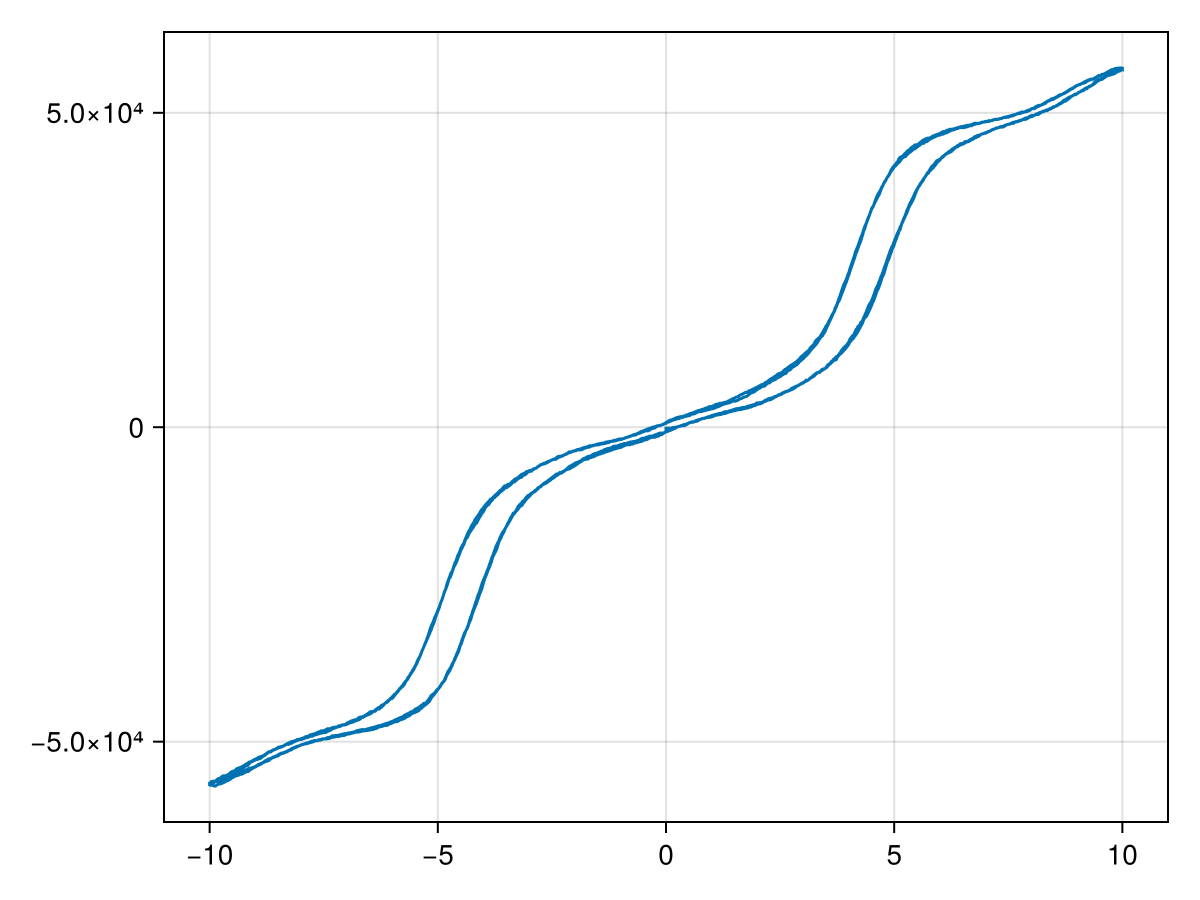

In [26]:
### Start with TrianlePulseA.

### We are using metropolis algrithm here. 
### fullsweep means: After xL*yL*zL updates, all dipoles are updated once.
### Time_fctr means: updating speed. Somehow this factor is relatived to real time
fullsweep = xL*yL*zL
Time_fctr = 0.2
SpeedRate = Int(Time_fctr*fullsweep)

### risepoint and Amptitude are factors from pulse
risepoint=500
Amptitude =10
# risepoint = round(Int, Amptitude/0.01)

### Run with TrianlePulseA
###  /\
### /  \    _____
###     \  /
###      \/

PulseN = 2
Pulsetime = (PulseN * 4 + 2) * risepoint * SpeedRate

compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
### estimate time
est_remaining(process(g))

# Wait until it is done
args = process(g) |> fetch # If you want to close ctr+c
# args = process(g) |> getargs
# EnergyG= args.all_Es;
voltage= args.x
Pr= args.y;

# w1=newmakie(lines, Pr, EnergyG)
inlineplot() do 
    lines(voltage, Pr)
end
w2=newmakie(lines, voltage, Pr)
w3=newmakie(lines,Pr)


In [20]:
temp(g)

1.5f0

In [38]:
### Check all values of dipoles 
state(g)

100000-element Vector{Float32}:
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
  ⋮
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0

In [ ]:
xL = 100  # Length in the x-dimension
yL = 100  # Length in the y-dimension
zL = 10   # Length in the z-dimension
g = IsingGraph(xL, yL, zL, stype = Continuous(), periodic = (:x,:y))
# Visual marker size (tune for clarity vs performance)
II.makie_markersize[] = 0.3

# Launch interactive visualization (idle until createProcess(...) later)
interface(g)

In [5]:
state(g)

100000-element Vector{Float32}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [ ]:
temp(g,10)
g.hamiltonian = Ising(g) + DepolField(g, c=60000, left_layers=1, right_layers=1)
g.hamiltonian = sethomogenousparam(g.hamiltonian, :b)

homogeneousself!(g,2)

# wg1 = @WG weightfunc_xy_antiferro NN = (2,2,2)
wg1 = @WG weightfunc1 NN = (1,1,1)
genAdj!(g[1], wg1)

fullsweep = xL*yL*zL
Time_fctr = 0.2
SpeedRate = Int(Time_fctr*fullsweep)

### risepoint and Amptitude are factors from pulse
risepoint=500
Amptitude =10
# risepoint = round(Int, Amptitude/0.01)

### Run with TrianlePulseA
###  /\
### /  \    _____
###     \  /
###      \/

PulseN = 2
Pulsetime = (PulseN * 4 + 2) * risepoint * SpeedRate

compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
### estimate time
est_remaining(process(g))

# Wait until it is done
args = process(g) |> fetch # If you want to close ctr+c
# args = process(g) |> getargs
# EnergyG= args.all_Es;
voltage= args.x
Pr= args.y;

# w1=newmakie(lines, Pr, EnergyG)
inlineplot() do 
    lines(voltage, Pr)
end
w2=newmakie(lines, voltage, Pr)
w3=newmakie(lines,Pr)

In [7]:
state(g)

100000-element Vector{Float32}:
  1.0
  1.0
  1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
  1.0
  1.0
  ⋮
  1.0
  1.0
 -1.0
 -1.0
  1.0
  1.0
  1.0
  1.0
  1.0